$\textbf{x}\in\Omega$

$$\textbf{a}(\textbf{x})\cdot\nabla u = \nabla\cdot(\mathsf{D}\cdot\nabla u) + r(\textbf{x})u + s(\textbf{x})$$

variational formulation $\forall v\in V$
$$\int_\Omega\text{d}\Omega~v\,\textbf{a}\cdot\nabla u + \nabla v\cdot(\mathsf{D}\cdot\nabla u) - vru - vs - \int_{\partial\Omega}\text{d}\Gamma~v\varepsilon\,\textbf{n}\cdot\nabla u=0$$


### $d=1$

$$\Omega = [0, L_x]$$
$$\textbf{a}=a\,\textbf{e}_x$$
$$\sigma=0$$
$$s = 1$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import (
    Form, CellDiameter, FacetNormal, dx, dS, 
    inner, grad, div, TestFunction, TrialFunction, Dx, 
    avg, sqrt, tanh, jump,
)

from lucifex.mesh import interval_mesh
from lucifex.fem import Function, Constant
from lucifex.solver import BoundaryValueProblem, bvp, BoundaryConditions
from lucifex.viz import plot_line
from lucifex.io import write
from lucifex.utils.py_utils import nested_dict
from lucifex.pde.transport_steady import advection_diffusion_steady
from lucifex.pde.supg import peclet



def adr_solver_1d(
    stabilization: str | None,
    Lx: float,
    Nx: int,
    dirichlet: tuple[float, float],
    eps: float, 
    a: float,
    sigma: float | None,
    s: float | None,
) -> tuple[BoundaryValueProblem, float]:
    mesh = interval_mesh(Lx, Nx)
    h = Lx / Nx

    Pe = peclet(h, a, eps)
    a = Constant(mesh, (a, ), name='a')
    eps = Constant(mesh, eps, name='eps')
    if sigma is not None:
        sigma = Constant(mesh, sigma, 'sigma')
    if s is not None:
        s = Constant(mesh, s, name='s')
    u = Function((mesh, 'P', 1), name='u')
    
    bcs = BoundaryConditions(
        ('dirichlet', lambda x: x[0], dirichlet[0]),
        ('dirichlet', lambda x: x[0] - Lx, dirichlet[1])
    )

    if stabilization == 'dg':
        bcs_strong = None
        bcs_weak = bcs
    else:
        bcs_strong = bcs
        bcs_weak = None

    u_solver = bvp(advection_diffusion_steady, bcs=bcs_strong)(
        u, a, eps, sigma, s, bcs_weak, stabilization,
    )

    return u_solver, Pe


a = 1.0
sigma = None
s = 1.0 
dirichlet = (0.0, 0.0)
Lx = 1.0
Nx = 10

stabilizations = (None, 'GLS', 'SUPG')
epsilons = (0.2, 1/18, 1/100)

results: dict[float, dict[str | None, Function]] = nested_dict(2)
peclets: dict[float, float] = {}

for eps in epsilons:
    for stbl in stabilizations:
        u_solver, Pe = adr_solver_1d(stbl, Lx, Nx, dirichlet, eps, a, sigma, s)
        u_solver.solve()
        results[Pe][stbl] = u_solver.solution
    peclets[Pe] = eps

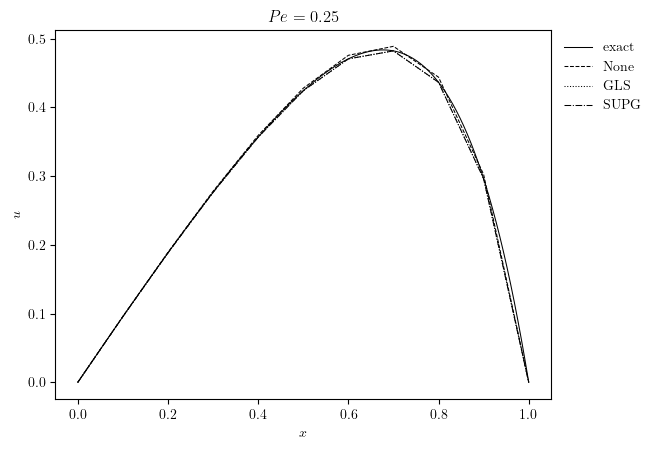

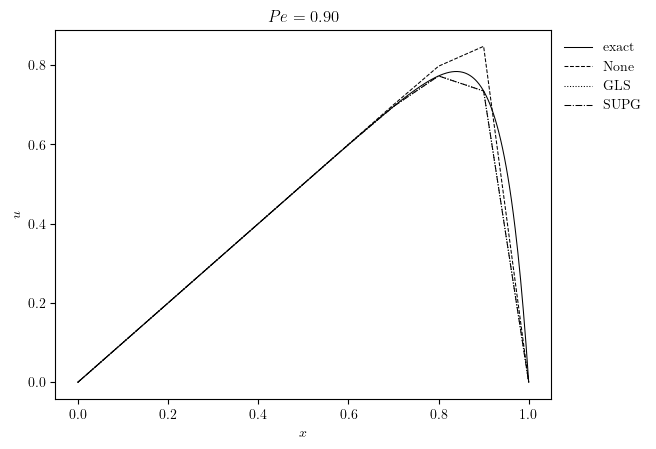

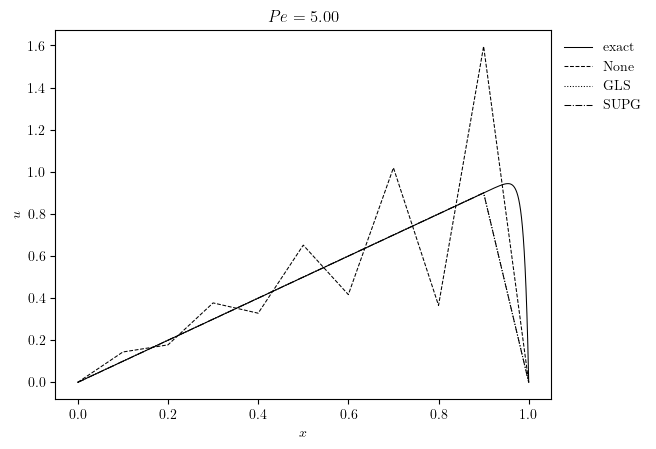

: 

In [ ]:
def exact_1d(
    x: np.ndarray, 
    a: float, 
    eps: float,
) -> np.ndarray:    
    return (1 / a) * (x - (1 - np.exp(a / eps * x)) / (1.0 - np.exp(a / eps)))

x = np.linspace(0, Lx, num=500)

for Pe, stbl_u in results.items():
    legend_labels = ['exact', *stbl_u.keys()]
    lines = [(x, exact_1d(x, a, peclets[Pe])), *(u for u in stbl_u.values())]
    fig, ax = plot_line(lines, legend_labels, x_label='$x$', y_label='$u$', title=f'$Pe={Pe:.2f}$')
    write(fig, f'N02_stabilized_steady_advection_diffusion_Pe={Pe:.2f}', './figures', close=False, pickle=False)

### $d=2$

$$\Omega = [0, L_x]\times[0,L_y]$$
$$\textbf{a}=(a\cos\theta,a\sin\theta)$$